In [16]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.pyplot as plt
import mapclassify as mc
import matplotlib.patches as mpatches
import libpysal as ps
import esda
import matplotlib.pyplot as plt
import os

In [19]:
#Loading data  
ddir = os.path.join('data')
file_path = os.path.join(ddir, 'greater_london.gpkg')  #full path

# loading GPKG
msoa_boundaries = gpd.read_file(file_path)

print("MSOA is loading.")
print(msoa_boundaries.head())

MSOA is loading.
    geo_code                 geo_label geo_labelw  \
0  E02000730                Newham 017       None   
1  E02000053                Barnet 030       None   
2  E02000243                Ealing 006       None   
3  E02000793  Richmond upon Thames 010       None   
4  E02000077                Bexley 013       None   

                                            geometry  
0  MULTIPOLYGON (((540612.745 184312.782, 540611....  
1  MULTIPOLYGON (((521244.462 190052.504, 521255....  
2  MULTIPOLYGON (((513445.352 183679.664, 513446....  
3  MULTIPOLYGON (((513496.024 174051.923, 513495....  
4  MULTIPOLYGON (((546675.313 176656.042, 546675....  


In [20]:
hotel_gdf = gpd.read_parquet("geodf/hotel_point.parquet")
print(hotel_gdf.head())
print("Coordinate Reference System (CRS):", hotel_gdf.crs)
print("Number of rows (using len):", len(hotel_gdf))

              id                                             name  \
0  node/25947730                                          Novotel   
1  node/26197001                                     Crowne Plaza   
2  node/29372721          Sundridge Park hotel and conference Ctr   
3  node/31314241  DoubleTree by Hilton Hotel London - Marble Arch   
4  node/59931333                               easyHotel Victoria   

        category subcategor       lon        lat  srid  \
0  ACCOMMODATION      HOTEL -0.455853  51.497544  4326   
1  ACCOMMODATION      HOTEL -0.454210  51.499441  4326   
2  ACCOMMODATION      HOTEL  0.037226  51.417030  4326   
3  ACCOMMODATION      HOTEL -0.156638  51.514571  4326   
4  ACCOMMODATION      HOTEL -0.142005  51.491988  4326   

                                     wkt    city image  ... housenumbe   fax  \
0          POINT (-0.4558534 51.4975442)    None  None  ...       None  None   
1          POINT (-0.4542096 51.4994407)    None  None  ...       None  None

In [21]:
airbnb_gdf = gpd.read_parquet("geodf/airbnb_listings_wgs84.parquet")
print(airbnb_gdf.head())
print("Coordinate Reference System (CRS):", airbnb_gdf.crs)

       id                                               name  host_id  \
0  116268  Double Room (Unavailable for check in 31Dec-1Jan)   586671   
1  117203            A stylish Victorian home in West London   255103   
2  127652                    Contemporary central London apt   134938   
3  127860  Double bedroom in cottage Twickenham (sleeps 1-2)   161720   
4  131444                         Apartment close to centre.   646165   

  host_name  neighbourhood_group           neighbourhood   latitude  \
0       Joe                  NaN                 Enfield  51.611370   
1      Olga                  NaN  Hammersmith and Fulham  51.501550   
2       Ron                  NaN                  Camden  51.559528   
3      Andy                  NaN    Richmond upon Thames  51.447770   
4  Yevgeniy                  NaN                 Lambeth  51.491476   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0  -0.118880     Private room   40.0               7       

In [22]:
#Change the point to a projected coordinate system

In [23]:
airbnb_gdf = airbnb_gdf.to_crs('epsg:27700') # There is no 'in_place=True' option here.
print(airbnb_gdf.geometry.crs)
print(airbnb_gdf.total_bounds)

epsg:27700
[504110.58907151 156900.42075072 559262.78761517 199928.53721747]


In [24]:
hotel_gdf = hotel_gdf.to_crs('epsg:27700') # There is no 'in_place=True' option here.
print(hotel_gdf.geometry.crs)
print(hotel_gdf.total_bounds)

epsg:27700
[503571.6272128  161799.45000483 555121.55250209 199244.93339842]


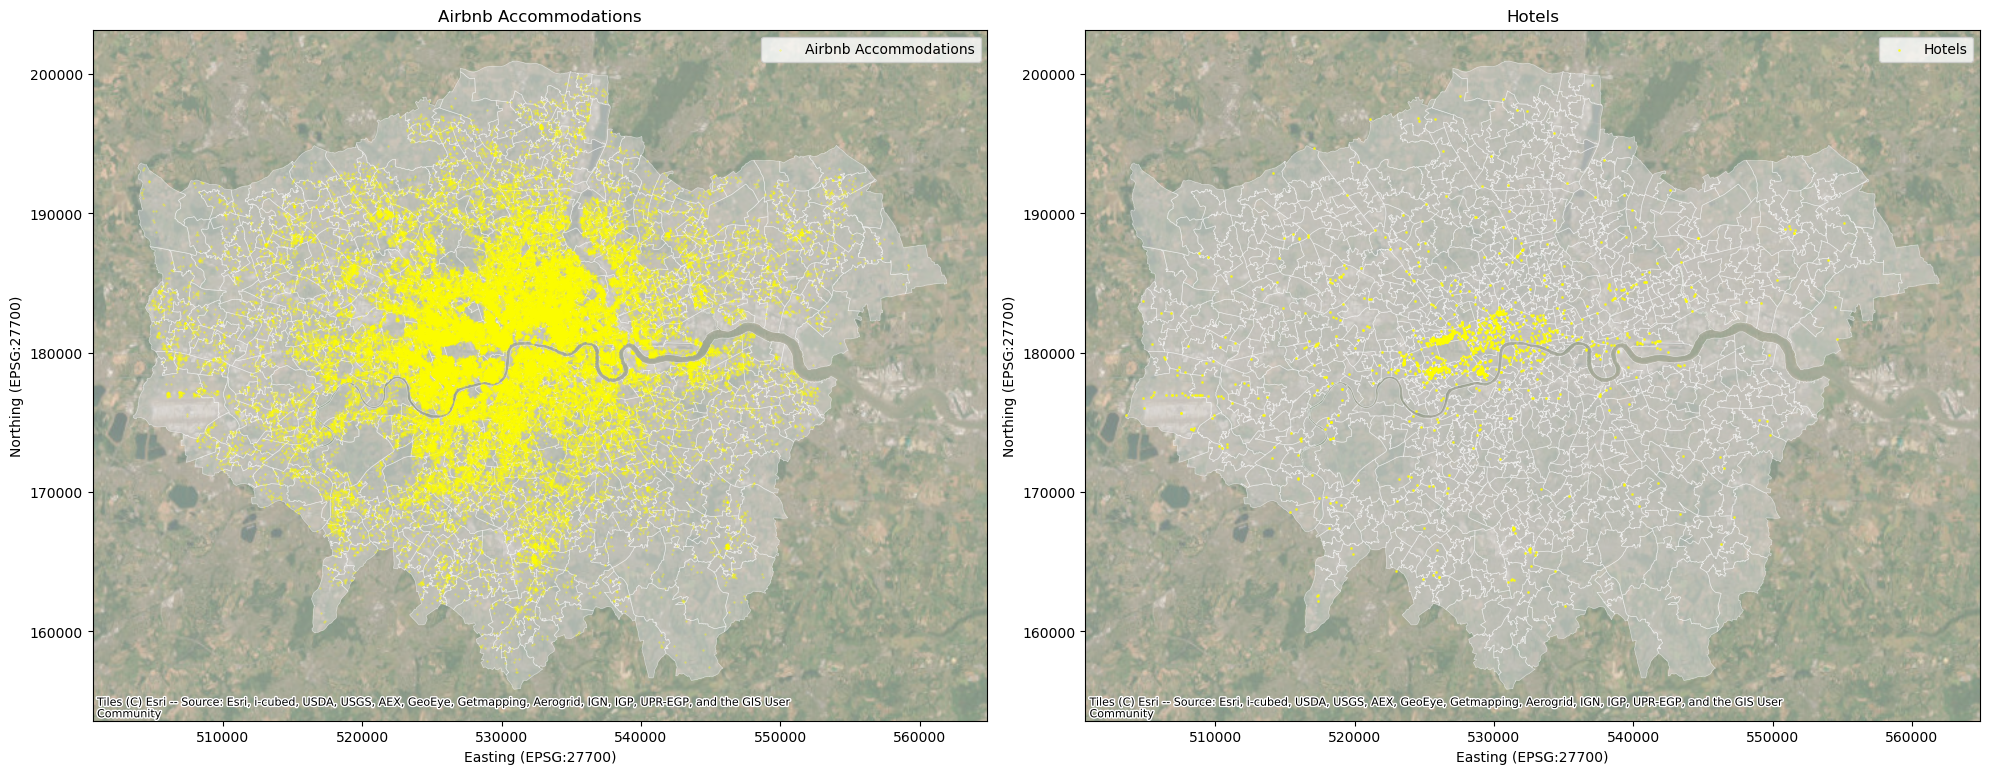

In [26]:
import matplotlib.pyplot as plt
import contextily as ctx


fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 一行两列，宽高比调整

# 1. Airbnb 
# MSOA 
msoa_boundaries.plot(ax=axes[0], color='lightgrey', edgecolor='white', alpha=0.5, linewidth=0.5)
# Airbnb 
airbnb_gdf.plot(ax=axes[0], markersize=0.1, color='yellow', alpha=0.7, label="Airbnb Accommodations")
# basemap
ctx.add_basemap(axes[0], source=ctx.providers.Esri.WorldImagery, crs=msoa_boundaries.crs, alpha=0.5)

axes[0].set_title("Airbnb Accommodations")
axes[0].set_xlabel("Easting (EPSG:27700)")
axes[0].set_ylabel("Northing (EPSG:27700)")
axes[0].legend()

# 2. Hotels 
# MSOA
msoa_boundaries.plot(ax=axes[1], color='lightgrey', edgecolor='white', alpha=0.5, linewidth=0.5)

hotel_gdf.plot(ax=axes[1], markersize=1, color='yellow', alpha=0.7, label="Hotels")

ctx.add_basemap(axes[1], source=ctx.providers.Esri.WorldImagery, crs=msoa_boundaries.crs, alpha=0.5)

axes[1].set_title("Hotels")
axes[1].set_xlabel("Easting (EPSG:27700)")
axes[1].set_ylabel("Northing (EPSG:27700)")
axes[1].legend()


plt.tight_layout()
plt.show()


In [28]:
#join the data  
# using spatial join to link Airbnb points to MSOA regions
airbnb_with_msoa = gpd.sjoin(airbnb_gdf, msoa_boundaries, how="inner", predicate='within')

# Counting the number of Airbnb points in each MSOA area
airbnb_count = airbnb_with_msoa.groupby('geo_code').size().reset_index(name='airbnb_count')

msoa_boundaries['area_m2'] = msoa_boundaries.geometry.area
# merge data
msoa_with_airbnb = msoa_boundaries.merge(airbnb_count, on='geo_code', how='left')

#nan=0
msoa_with_airbnb['airbnb_count'] = msoa_with_airbnb['airbnb_count'].fillna(0)

msoa_with_airbnb['density'] = msoa_with_airbnb['airbnb_count'] / msoa_with_airbnb['area_m2']

print(msoa_with_airbnb[['geo_code', 'airbnb_count', 'area_m2', 'density']].head())

    geo_code  airbnb_count       area_m2   density
0  E02000730            27  5.034109e+05  0.000054
1  E02000053           202  1.550097e+06  0.000130
2  E02000243            43  2.845748e+06  0.000015
3  E02000793            50  1.326445e+06  0.000038
4  E02000077            20  1.117333e+06  0.000018


In [29]:
# Standardised formula：Min-Max Scaling
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())


msoa_with_airbnb['nairbnb_count'] = min_max_scaling(msoa_with_airbnb['airbnb_count'])
msoa_with_airbnb['n_density'] = min_max_scaling(msoa_with_airbnb['density'])


print(msoa_with_airbnb[['geo_code', 'airbnb_count', 'nairbnb_count', 'density', 'n_density']].head())

    geo_code  airbnb_count  nairbnb_count   density  n_density
0  E02000730            27       0.020342  0.000054   0.031599
1  E02000053           202       0.162734  0.000130   0.076907
2  E02000243            43       0.033360  0.000015   0.008836
3  E02000793            50       0.039056  0.000038   0.022181
4  E02000077            20       0.014646  0.000018   0.010485


In [30]:
# Generating descriptive statistics
msoa_stats = msoa_with_airbnb[['airbnb_count', 'nairbnb_count', 'density', 'n_density']].describe()

print(msoa_stats)

       airbnb_count  nairbnb_count       density   n_density
count    983.000000     983.000000  9.830000e+02  983.000000
mean      97.845371       0.077986  1.297690e-04    0.076584
std      124.539112       0.101334  2.068663e-04    0.122231
min        2.000000       0.000000  1.552726e-07    0.000000
25%       23.000000       0.017087  1.295623e-05    0.007564
50%       53.000000       0.041497  4.525557e-05    0.026648
75%      127.000000       0.101709  1.589662e-04    0.093836
max     1231.000000       1.000000  1.692583e-03    1.000000


In [31]:
#Join hotel data
hotels_with_msoa = gpd.sjoin(hotel_gdf, msoa_with_airbnb, how="inner", predicate="within")
hotel_count = hotels_with_msoa.groupby('geo_code').size().reset_index(name='hotel_count')
msoa_with_airbnb_hotels = msoa_with_airbnb.merge(hotel_count, on='geo_code', how='left')
msoa_with_airbnb_hotels['hotel_count'] = msoa_with_airbnb_hotels['hotel_count'].fillna(0)
msoa_with_airbnb_hotels['hotel_density'] = msoa_with_airbnb_hotels['hotel_count'] / msoa_with_airbnb_hotels['area_m2']


print(msoa_with_airbnb_hotels[['geo_code', 'hotel_count', 'area_m2', 'hotel_density']].head())

    geo_code  hotel_count       area_m2  hotel_density
0  E02000730          0.0  5.034109e+05   0.000000e+00
1  E02000053          0.0  1.550097e+06   0.000000e+00
2  E02000243          1.0  2.845748e+06   3.514015e-07
3  E02000793          0.0  1.326445e+06   0.000000e+00
4  E02000077          0.0  1.117333e+06   0.000000e+00


In [32]:
# Standardised formula：Min-Max Scaling
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())


msoa_with_airbnb_hotels['nhotel_count'] = min_max_scaling(msoa_with_airbnb_hotels['hotel_count'])
msoa_with_airbnb_hotels['nhotel_density'] = min_max_scaling(msoa_with_airbnb_hotels['hotel_density'])


print(msoa_with_airbnb_hotels[['geo_code', 'hotel_count', 'nhotel_count', 'nhotel_density', 'hotel_density']].head())

    geo_code  hotel_count  nhotel_count  nhotel_density  hotel_density
0  E02000730          0.0      0.000000        0.000000   0.000000e+00
1  E02000053          0.0      0.000000        0.000000   0.000000e+00
2  E02000243          1.0      0.011765        0.002412   3.514015e-07
3  E02000793          0.0      0.000000        0.000000   0.000000e+00
4  E02000077          0.0      0.000000        0.000000   0.000000e+00


In [33]:
# Generating descriptive statistics
msoa_stats = msoa_with_airbnb_hotels[['airbnb_count', 'nairbnb_count', 'density', 'n_density','hotel_count', 'nhotel_count', 'nhotel_density', 'hotel_density']].describe()

print(msoa_stats)

       airbnb_count  nairbnb_count       density   n_density  hotel_count  \
count    983.000000     983.000000  9.830000e+02  983.000000   983.000000   
mean      97.845371       0.077986  1.297690e-04    0.076584     1.405900   
std      124.539112       0.101334  2.068663e-04    0.122231     5.563835   
min        2.000000       0.000000  1.552726e-07    0.000000     0.000000   
25%       23.000000       0.017087  1.295623e-05    0.007564     0.000000   
50%       53.000000       0.041497  4.525557e-05    0.026648     0.000000   
75%      127.000000       0.101709  1.589662e-04    0.093836     1.000000   
max     1231.000000       1.000000  1.692583e-03    1.000000    85.000000   

       nhotel_count  nhotel_density  hotel_density  
count    983.000000      983.000000   9.830000e+02  
mean       0.016540        0.013407   1.953306e-06  
std        0.065457        0.069378   1.010797e-05  
min        0.000000        0.000000   0.000000e+00  
25%        0.000000        0.000000   0.0

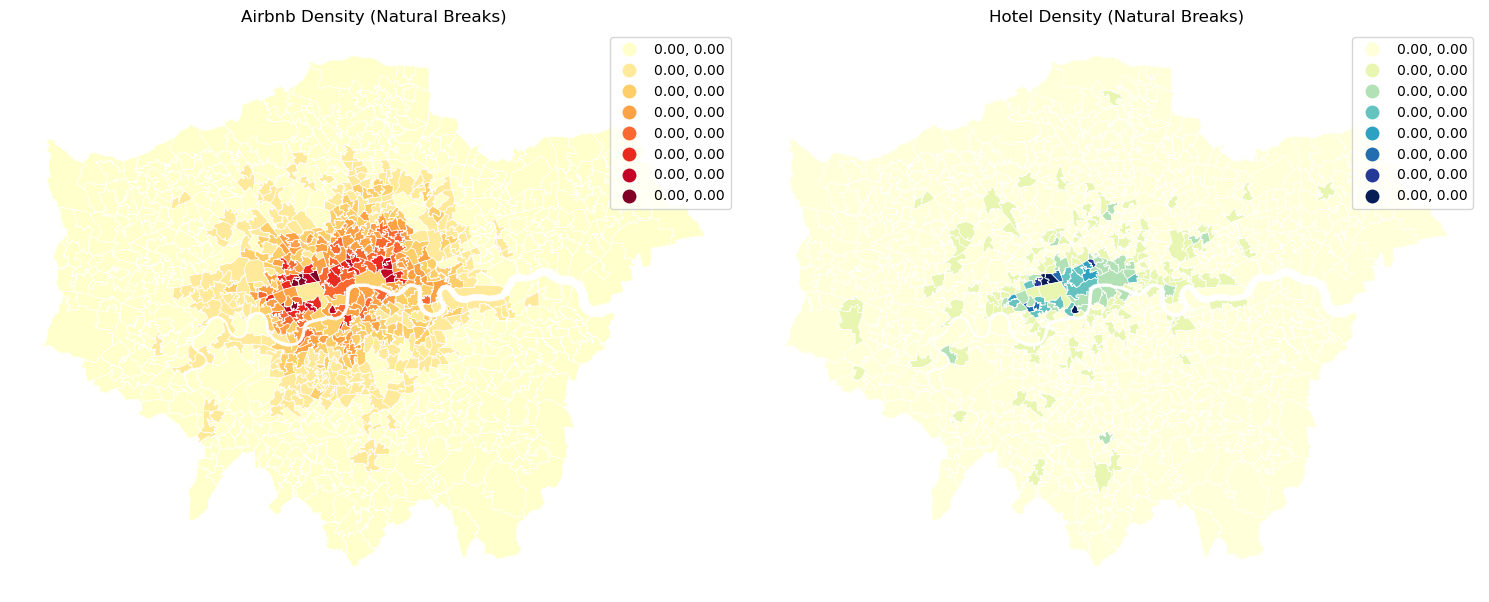

In [34]:
import matplotlib.pyplot as plt
import mapclassify as mc


fig, axes = plt.subplots(1, 2, figsize=(15, 7))


scheme_density = mc.NaturalBreaks(msoa_with_airbnb_hotels['density'], k=8)
msoa_with_airbnb_hotels.plot(
    column='density',
    cmap='YlOrRd',
    legend=True,
    linewidth=0.5,
    edgecolor='white',
    scheme='natural_breaks',
    classification_kwds={'k': 8},
    ax=axes[0]
)
axes[0].set_title("Airbnb Density (Natural Breaks)")
axes[0].set_axis_off()


scheme_hotel_density = mc.NaturalBreaks(msoa_with_airbnb_hotels['hotel_density'], k=8)
msoa_with_airbnb_hotels.plot(
    column='hotel_density',
    cmap='YlGnBu',
    legend=True,
    linewidth=0.5,
    edgecolor='white',
    scheme='natural_breaks',
    classification_kwds={'k': 8},
    ax=axes[1]
)
axes[1].set_title("Hotel Density (Natural Breaks)")
axes[1].set_axis_off()

# layout
plt.tight_layout()
plt.show()

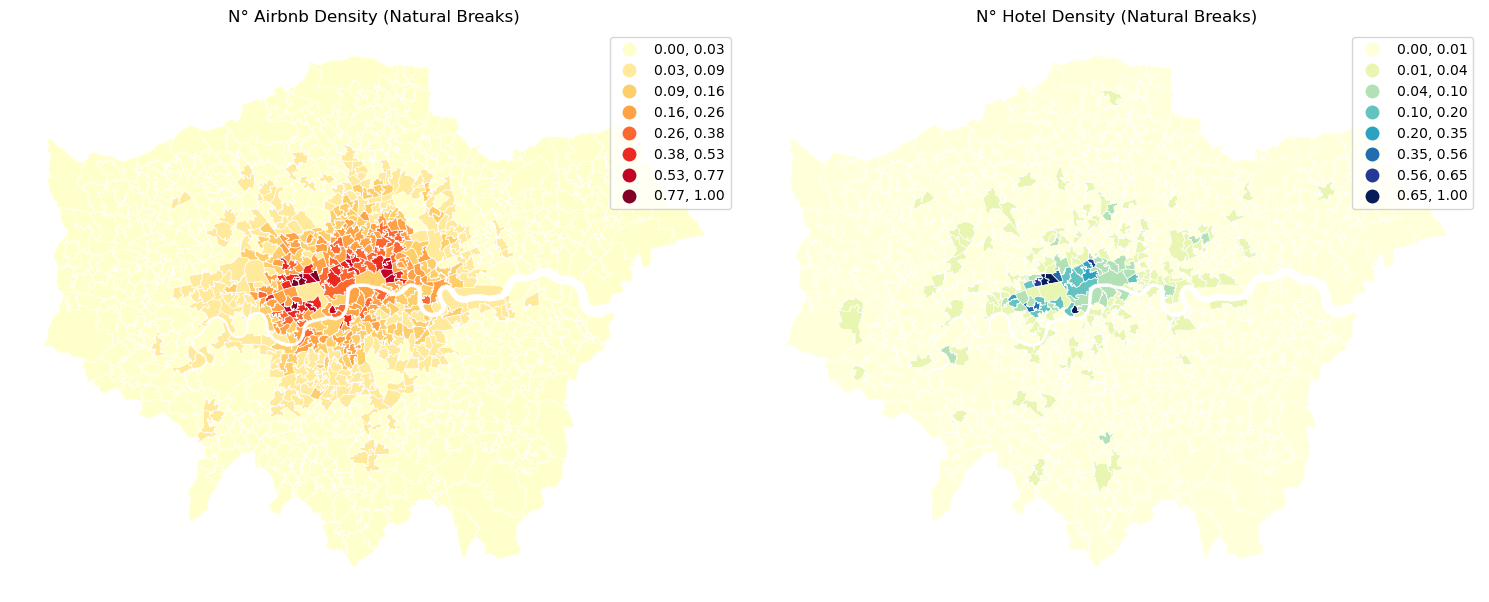

In [35]:
#Standardised density
import matplotlib.pyplot as plt
import mapclassify as mc  # 导入 mapclassify

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

scheme_density = mc.NaturalBreaks(msoa_with_airbnb_hotels['n_density'], k=8)
msoa_with_airbnb_hotels.plot(
    column='n_density',
    cmap='YlOrRd',
    legend=True,
    linewidth=0.5,
    edgecolor='white',
    scheme='natural_breaks',
    classification_kwds={'k': 8},
    ax=axes[0]
)
axes[0].set_title("N° Airbnb Density (Natural Breaks)")
axes[0].set_axis_off()

scheme_hotel_density = mc.NaturalBreaks(msoa_with_airbnb_hotels['nhotel_density'], k=8)
msoa_with_airbnb_hotels.plot(
    column='nhotel_density',
    cmap='YlGnBu',
    legend=True,
    linewidth=0.5,
    edgecolor='white',
    scheme='natural_breaks',
    classification_kwds={'k': 8},
    ax=axes[1]
)
axes[1].set_title("N° Hotel Density (Natural Breaks)")
axes[1].set_axis_off()


plt.tight_layout()
plt.show()

通过对Airbnb和酒店密度的对比可以发现，Airbnb的分布范围明显更广，高密度区域主要集中在伦敦市中心及周边地区，比如泰晤士河沿线、西区和南岸等热门旅游区和居民区。与此同时，Airbnb的密度逐渐向外递减，显示出其市场正在向外围住宅区扩散，具有很强的灵活性和渗透力。而酒店的分布则高度集中在伦敦的核心区域，尤其围绕泰晤士河沿线和商业旅游热点，这些区域的酒店密度最高，但范围相对较小，几乎没有向外围扩展，表明酒店市场更依赖市中心的旅游和商业开发。从中可以看出，Airbnb不仅在中心区占据优势，还在外围地区显示出潜在的市场扩展能力，而酒店市场在外围区域的缺失反映出其对非传统区域住宿需求的适应性较差。总体而言，Airbnb的分布更广泛且灵活，而酒店的分布更集中但范围受限。

A comparison of Airbnb and hotel densities shows that Airbnb is significantly more widely distributed, with high-density areas concentrated in and around central London, such as popular tourist and residential areas along the Thames, the West End and the South Bank. At the same time, Airbnb's density gradually decreases outwards, showing that its market is spreading to peripheral residential areas, with a high degree of flexibility and penetration. The distribution of hotels, on the other hand, is highly concentrated in London's core areas, particularly around the Thames riverfront and business tourism hotspots, which have the highest density of hotels, but are relatively small in scope with little expansion to the periphery, suggesting that the hotel market is more reliant on tourism and business development in the city centre. It is clear from this that Airbnb not only dominates in the centre, but also shows potential market expansion in peripheral areas, while the hotel market's lack of presence in peripheral areas reflects its poor adaptation to the demand for accommodation in non-traditional areas. Overall, Airbnb's distribution is broader and more flexible, while hotels are more centralised but restricted in scope.

In [42]:
# density Global Moran's I
density = msoa_with_airbnb_hotels['density'].fillna(0)
moran_density = esda.Moran(density, w)

# hotel_density Global Moran's I
hotel_density = msoa_with_airbnb_hotels['hotel_density'].fillna(0)
moran_hotel_density = esda.Moran(hotel_density, w)


print("Global Moran's I for Density:")
print(f"I: {moran_density.I:.4f}, p-value: {moran_density.p_sim:.4f}, z-score: {moran_density.z_sim:.4f}")

print("\nGlobal Moran's I for Hotel Density:")
print(f"I: {moran_hotel_density.I:.4f}, p-value: {moran_hotel_density.p_sim:.4f}, z-score: {moran_hotel_density.z_sim:.4f}")

Global Moran's I for Density:
I: 0.7242, p-value: 0.0010, z-score: 37.8009

Global Moran's I for Hotel Density:
I: 0.3534, p-value: 0.0010, z-score: 19.6565


In [36]:
# Local Moran's I analysis  
import libpysal as ps
import esda
import geopandas as gpd
import matplotlib.pyplot as plt

In [37]:
#Computational space matrix
w = ps.weights.Queen.from_dataframe(msoa_with_airbnb_hotels, use_index=True)
w.transform = 'r'

In [38]:
def recompute_lisa(gdf, column, output_column, significance=0.05):
    """
    重新计算 Local Moran's I 并将结果保存到指定列。
    参数:
        gdf: GeoDataFrame
        column: 进行 LISA 计算的列名
        output_column: 保存四象限分类结果的列名
        significance: 显著性水平
    """
    gdf = gdf.copy()  # 避免修改原始数据
    from scipy.stats import zscore
    
    # 标准化变量（z-score）
    gdf['z_value'] = zscore(gdf[column])
    
    # 计算 Local Moran's I
    moran_loc = esda.Moran_Local(gdf[column], w)
    
    # 初始化分类
    gdf['local_moran'] = moran_loc.Is
    gdf['p_sim'] = moran_loc.p_sim
    gdf[output_column] = 0  # 非显著区域初始化为0

    # 四象限分类逻辑
    sig = gdf['p_sim'] < significance  # 显著性检验
    high = gdf['z_value'] > 0          # 高值区
    low = ~high                        # 低值区

    gdf.loc[sig & high & (moran_loc.z_sim > 0), output_column] = 1  # HH (High-High)
    gdf.loc[sig & low & (moran_loc.z_sim < 0), output_column] = 2  # LL (Low-Low)
    gdf.loc[sig & high & (moran_loc.z_sim < 0), output_column] = 3  # HL (High-Low)
    gdf.loc[sig & low & (moran_loc.z_sim > 0), output_column] = 4  # LH (Low-High)

    return gdf

In [39]:
# 重新计算 Local Moran's I 并保存到不同列
msoa_with_airbnb_hotels = recompute_lisa(
    gdf=msoa_with_airbnb_hotels,
    column='density',
    output_column='quadrant_density',
    significance=0.05
)

msoa_with_airbnb_hotels = recompute_lisa(
    gdf=msoa_with_airbnb_hotels,
    column='hotel_density',
    output_column='quadrant_hotel_density',
    significance=0.05
)

# 查看结果
print(msoa_with_airbnb_hotels[['geo_code', 'quadrant_density', 'quadrant_hotel_density']].head())

    geo_code  quadrant_density  quadrant_hotel_density
0  E02000730                 0                       0
1  E02000053                 0                       0
2  E02000243                 4                       0
3  E02000793                 0                       0
4  E02000077                 4                       0


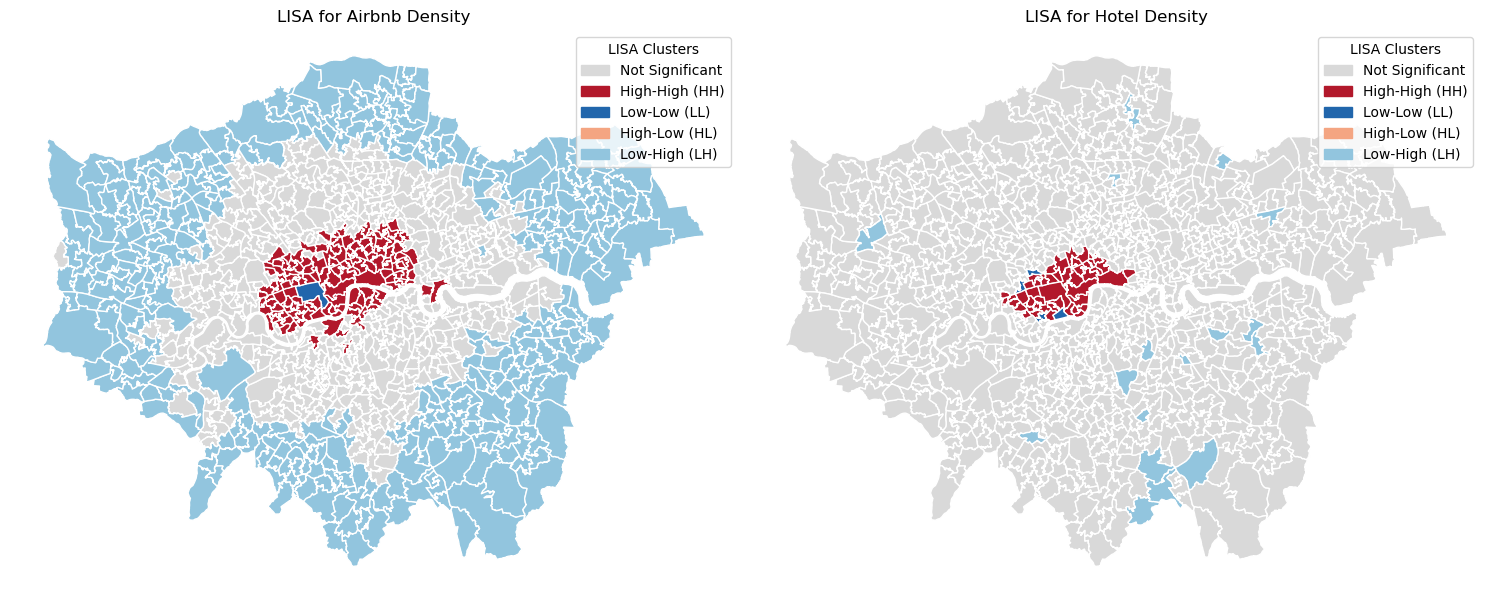

LISA空间聚类图显示，Airbnb在市中心形成了连续带状的高-高聚类，向外围住宅区逐步扩散，表现出强烈的空间延展性。而酒店的高-高聚类在市中心呈现点状集中分布，主要局限于核心商业和旅游区，外围区域几乎没有显著聚类，缺乏扩展和连贯性。

The LISA spatial clustering map shows that Airbnb forms a continuous band of high-high clustering in the city centre, gradually spreading to the peripheral residential areas, showing strong spatial extensibility. On the other hand, the high - high clustering of hotels shows a point-like concentrated distribution in the city centre, which is mainly confined to the core business and tourist areas, with almost no significant clustering in the peripheral areas, lacking extension and coherence.

In [56]:
density = msoa_with_airbnb_hotels['density'].fillna(0)
moran_density = esda.Moran(density, w)

# 计算 hotel_density 的 Global Moran's I
hotel_density = msoa_with_airbnb_hotels['hotel_density'].fillna(0)
moran_hotel_density = esda.Moran(hotel_density, w)

# 打印结果
print("Global Moran's I for Density:")
print(f"I: {moran_density.I:.4f}, p-value: {moran_density.p_sim:.4f}, z-score: {moran_density.z_sim:.4f}")

print("\nGlobal Moran's I for Hotel Density:")
print(f"I: {moran_hotel_density.I:.4f}, p-value: {moran_hotel_density.p_sim:.4f}, z-score: {moran_hotel_density.z_sim:.4f}")

Global Moran's I for Density:
I: 0.7242, p-value: 0.0010, z-score: 38.5913

Global Moran's I for Hotel Density:
I: 0.3534, p-value: 0.0010, z-score: 19.0337


In [45]:
tdf = pd.read_csv("geodf/london_tourism_area.csv")

In [47]:
# 确保两个表中的连接列名称和数据类型一致
tdf['MSOA11CD'] = tdf['MSOA11CD'].astype(str)  # 将 tdf 的 MSOA11CD 转换为字符串类型
msoa_with_airbnb_hotels['geo_code'] = msoa_with_airbnb_hotels['geo_code'].astype(str)  # 确保 geo_cd 也是字符串

# 执行连接
msoa_with_airbnb_hotels = msoa_with_airbnb_hotels.merge(
    tdf,
    left_on='geo_code',        # msoa_with_airbnb_hotels 中的列
    right_on='MSOA11CD',     # tdf 中的列
    how='left'               # 左连接，保留 msoa_with_airbnb_hotels 中所有行
)

# 如果需要删除重复的列
msoa_with_airbnb_hotels = msoa_with_airbnb_hotels.drop(columns=['MSOA11CD'])

# 查看合并后的结果
print(msoa_with_airbnb_hotels.head())


    geo_code                 geo_label geo_labelw  \
0  E02000730                Newham 017       None   
1  E02000053                Barnet 030       None   
2  E02000243                Ealing 006       None   
3  E02000793  Richmond upon Thames 010       None   
4  E02000077                Bexley 013       None   

                                            geometry       area_m2  \
0  MULTIPOLYGON (((540612.745 184312.782, 540611....  5.034109e+05   
1  MULTIPOLYGON (((521244.462 190052.504, 521255....  1.550097e+06   
2  MULTIPOLYGON (((513445.352 183679.664, 513446....  2.845748e+06   
3  MULTIPOLYGON (((513496.024 174051.923, 513495....  1.326445e+06   
4  MULTIPOLYGON (((546675.313 176656.042, 546675....  1.117333e+06   

   airbnb_count   density  nairbnb_count  n_density  hotel_count  ...  \
0            27  0.000054       0.020342   0.031599          0.0  ...   
1           202  0.000130       0.162734   0.076907          0.0  ...   
2            43  0.000015       0.033360 

In [ ]:
#tradtional area and non_traditional_area           

In [50]:

traditional_area = msoa_with_airbnb_hotels[msoa_with_airbnb_hotels['hotspot_binary'] == 1]
non_traditional_area = msoa_with_airbnb_hotels[msoa_with_airbnb_hotels['hotspot_binary'] == 0]

traditional_stats = traditional_area['airbnb_count'].describe()
non_traditional_stats = non_traditional_area['airbnb_count'].describe()

print("Traditional Tourist Area Listings Statistics:")
print(traditional_stats)

print("\nNon-Traditional Areas Airbnb Listing Statistics")

print(non_traditional_stats)


Traditional Tourist Area Listings Statistics:
count     171.000000
mean      276.725146
std       186.894341
min        59.000000
25%       152.500000
50%       228.000000
75%       341.000000
max      1231.000000
Name: airbnb_count, dtype: float64

Non-Traditional Areas Airbnb Listing Statistics
count    812.000000
mean      60.174877
std       57.365735
min        2.000000
25%       20.000000
50%       40.000000
75%       81.250000
max      459.000000
Name: airbnb_count, dtype: float64


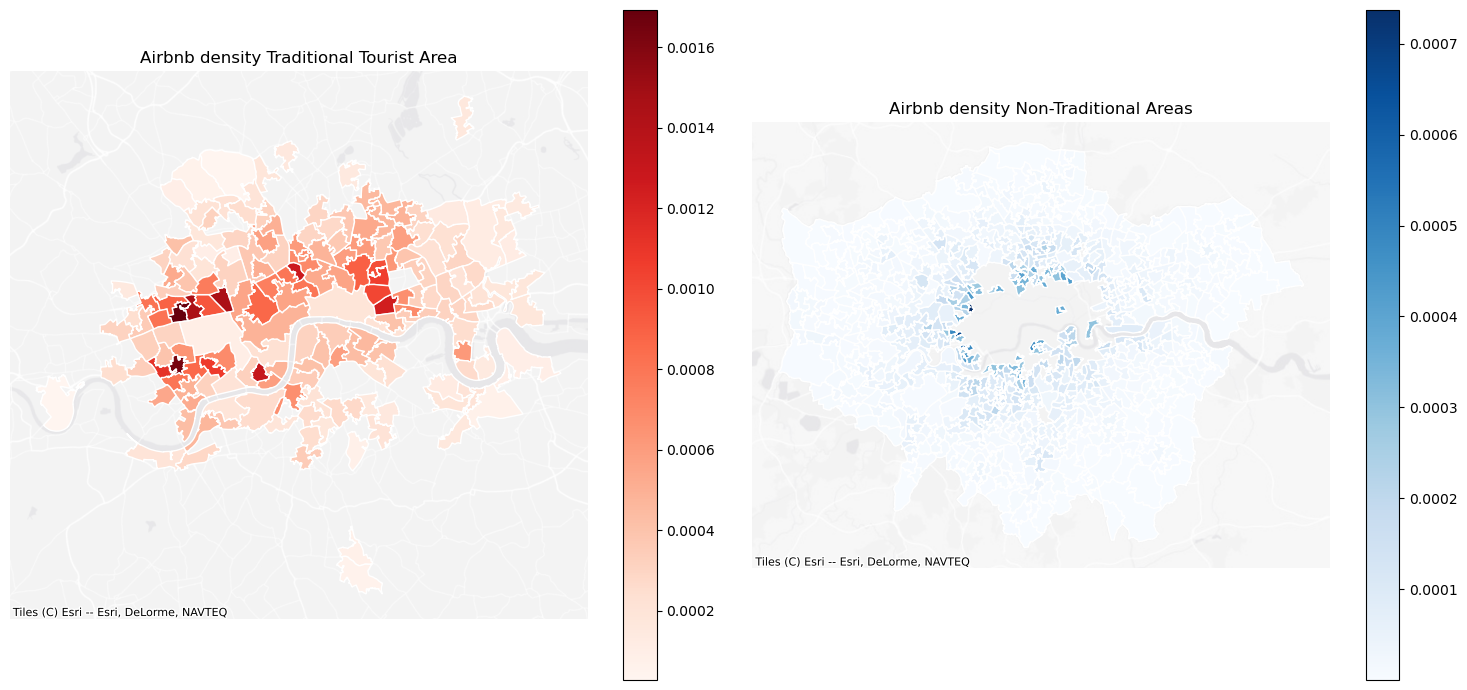

In [54]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

traditional_area.plot(column='density', cmap='Reds', edgecolor='white', legend=True, ax=ax[0])
ctx.add_basemap(ax[0], source=ctx.providers.Esri.WorldGrayCanvas, crs=traditional_area.crs, alpha=0.5)
ax[0].set_title("Airbnb density Traditional Tourist Area")
ax[0].axis("off")

non_traditional_area.plot(column='density', cmap='Blues', edgecolor='white', legend=True, ax=ax[1])
ctx.add_basemap(ax[1], source=ctx.providers.Esri.WorldGrayCanvas, crs=non_traditional_area.crs, alpha=0.5)
ax[1].set_title("Airbnb density Non-Traditional Areas")
ax[1].axis("off")

plt.tight_layout()
plt.show()



从图中可以看出，Airbnb在传统旅游区与非传统区域的分布表现出功能需求的梯度差异。在传统旅游区（左图），Airbnb房源密度形成了明显的高密度热点区域，与主要旅游景点和中心区紧密重叠，反映出Airbnb在这些区域对旅游住宿需求的高度响应。而在非传统区域（右图），Airbnb的分布呈现出零散低密度的特征，没有形成明显的聚集现象，显示出这些区域对短期住宿需求的市场吸引力较低。

这种分布模式表明，Airbnb在传统旅游区起到了核心支撑作用，而非传统区域尚未成为主要的住宿选择，市场渗透仍处于较低水平，未来有待进一步开发与引导。

The map shows a gradient difference in functional demand for Airbnb between traditional tourist areas and non-traditional areas. In traditional tourist areas (left), Airbnb listings form distinct high-density hotspots, closely aligned with major tourist attractions and central zones, reflecting Airbnb’s strong response to tourism-driven accommodation demand. In non-traditional areas (right), Airbnb distribution appears scattered and low-density, with no significant clustering, indicating limited market appeal for short-term accommodation in these regions.

This pattern suggests that Airbnb plays a core role in supporting tourism within traditional areas, while non-traditional areas have yet to become a significant accommodation choice, with market penetration remaining low and potential for future growth and development.